In [1]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

In [3]:
%matplotlib inline

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:

# Assuming `df` is a pandas DataFrame with the following columns:
# 'Category' for domain categories like 'Enzyme activity', 'Binding', etc.
# 'Method' for different computational methods
# 'Correlation' for Spearman correlation values
# 'MSA_Size' for MSA effective size, which could affect the size of the markers

# Example data (this should be replaced with your actual data)
np.random.seed(0)
n = 50  # number of points
df = pd.DataFrame({
    'Category': np.random.choice(['Enzyme activity', 'Binding', 'Other'], size=n),
    'Method': np.random.choice(['Augmented EVmutation Potts', 'DeepSequence VAE', 'eUniRep regression'], size=n),
    'Correlation': np.random.uniform(0.2, 0.8, size=n),
    'MSA_Size': np.random.choice([48, 4530, 15462], size=n)
})

# Map methods to markers
marker_dict = {
    'Augmented EVmutation Potts': 'v',
    'DeepSequence VAE': 'o',
    'eUniRep regression': '^'
}

# Map MSA sizes to point sizes
size_dict = {48: 50, 4530: 150, 15462: 300}

# Create a color palette
palette = sns.color_palette("hsv", len(df['Method'].unique()))
color_dict = dict(zip(df['Method'].unique(), palette))


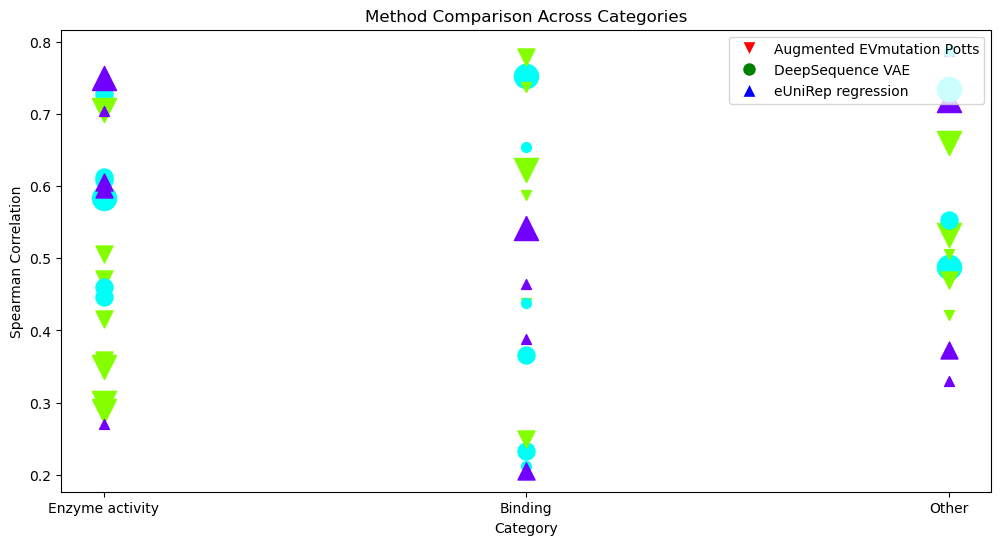

In [5]:
# Create a large figure
plt.figure(figsize=(12, 6))

# Loop through each category to create subplots or sections in a single plot
for category in df['Category'].unique():
    subset = df[df['Category'] == category]
    for i, row in subset.iterrows():
        plt.scatter(x=category, y=row['Correlation'], marker=marker_dict[row['Method']],
                    color=color_dict[row['Method']], s=size_dict[row['MSA_Size']])

# Customizing the plot
plt.xlabel('Category')
plt.ylabel('Spearman Correlation')
plt.title('Method Comparison Across Categories')

# Creating a custom legend for markers
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='v', color='w', label='Augmented EVmutation Potts',
                          markerfacecolor='r', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='DeepSequence VAE',
                          markerfacecolor='g', markersize=10),
                   Line2D([0], [0], marker='^', color='w', label='eUniRep regression',
                          markerfacecolor='b', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')

# Show plot
plt.show()


In [6]:
mlde_all = pd.read_csv("results/mlde/all_df_comb_onehot.csv")

In [7]:
from SSMuLA.landscape_global import LIB_TYPES

In [17]:
active_lib_list = [
    "DHFR",
    "ParD2",
    "ParD3",
    "GB1",
    "TrpB3D",
    "TrpB3E",
    "TrpB3F",
    "TrpB3G",
    "TrpB3I",
    "TrpB4",
]

In [10]:
N_SAMPLE_LIST = [24, 48, 96, 192, 288, 384, 480, 576, 960, 1920]
FTLIB_FRAC_LIST = [0.125, 0.25, 0.5, 1]

In [11]:
# ft only 12.5
def get_mlde_avg_sdf(mlde_all, n_top, n_mut_cutoff, zs_list, active_lib_list, ft_frac = 0.125):
    slice_mlde = mlde_all[
        (mlde_all["lib"].isin(active_lib_list))
        & (mlde_all["zs"].isin(zs_list))
        & (mlde_all["n_top"] == n_top)
        & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
    ]

    if "none" not in zs_list:
        lib_dfs = []
        for lib in active_lib_list:
            lib_df = slice_mlde[slice_mlde["lib"] == lib].copy()
            lib_df["ft_lib_size"] = lib_df["ft_lib"].map(
                {
                    numb: frac
                    for numb, frac in zip(
                        sorted(lib_df["ft_lib"].unique()), FTLIB_FRAC_LIST
                    )
                }
            )
            lib_dfs.append(lib_df[lib_df["ft_lib_size"] == ft_frac])
        slice_mlde = pd.concat(lib_dfs)

    avg_mlde = slice_mlde[["n_sample", "top_maxes", "if_truemaxs"]].groupby("n_sample").agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    avg_mlde = avg_mlde.rename(columns={'n_sample_': 'n_sample'}).set_index("n_sample")
    return avg_mlde

In [12]:
def get_mlde_avg_df(mlde_all, n_top, n_mut_cutoff, zs, active_lib_list):
    avg_mlde = mlde_all[
        (mlde_all["lib"].isin(active_lib_list))
        & (mlde_all["zs"].isin(zs))
        & (mlde_all["n_top"] == n_top)
        & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
    ][["n_sample", "top_maxes", "if_truemaxs"]].groupby("n_sample").agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    avg_mlde = avg_mlde.rename(columns={'n_sample_': 'n_sample'}).set_index("n_sample")
    return avg_mlde

In [22]:
from SSMuLA.zs_analysis import ZS_OPTS
from SSMuLA.vis import PRESENTATION_PALETTE_SATURATE

%matplotlib inline

In [15]:
ZS_OPTS

['ed_score', 'Triad_score', 'ev_score', 'esm_score', 'esmif_score']

In [19]:
FTLIB_FRAC_LIST[:-1]

[0.125, 0.25, 0.5]

In [20]:
# for avg cross number of samples
n_top = 96
n_corr = 384

random_avg = get_mlde_avg_df(mlde_all, n_top, "all", ["none"], active_lib_list)

frac_ft_dict = {}

for frac in FTLIB_FRAC_LIST[:-1]:
    avg_mlde = get_mlde_avg_sdf(mlde_all, n_top, "all", ZS_OPTS, active_lib_list, ft_frac = frac)
    frac_ft_dict[frac] = avg_mlde

Text(0.5, 0.95, 'ftMLDE Varying Focused Libraries Fraction Across 10 Landscapes')

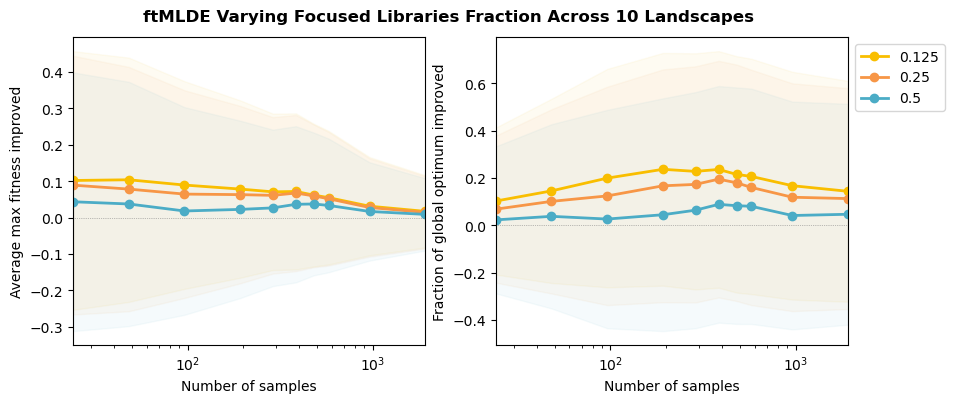

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mlde_color_list = ["yellow", "orange", "blue"]

for ax, mlde_metric, de_metric, y_label in zip(
    axes,
    ["top_maxes", "if_truemaxs"],
    ["mean_all", "fraction_max"],
    ["Average max fitness", "Fraction of global optimum"],
):

    for i, (frac_ft, frac_ft_df) in enumerate(frac_ft_dict.items()):
        delta_df = frac_ft_df - random_avg

        ax.plot(
            delta_df.index,
            delta_df[f"{mlde_metric}_mean"],
            label=str(frac_ft),
            marker="o",
            linestyle="solid",
            linewidth=2,
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
        )
        ax.fill_between(
            delta_df.index,
            delta_df[f"{mlde_metric}_mean"] - random_avg[f"{mlde_metric}_std"],
            delta_df[f"{mlde_metric}_mean"] + random_avg[f"{mlde_metric}_std"],
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
            alpha=0.05,
        )
        
    # # add vline
    # ax.axvline(
    #     n_corr,
    #     color="gray",
    #     linewidth=0.5,
    #     linestyle="dotted"
    # )
    # add hline
    ax.axhline(
        0,
        color="gray",
        linewidth=0.5,
        linestyle="dotted"
    )

    ax.set_xlim(N_SAMPLE_LIST[0], N_SAMPLE_LIST[-1])
    # ax.set_ylim(0, 1.0)

    ax.set_xscale("log")
    ax.set_xlabel("Number of samples")
    ax.set_ylabel(f"{y_label} improved")

    if ax == axes[1]:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

fig.suptitle(
    "ftMLDE Varying Focused Libraries Fraction Across 10 Landscapes", fontsize=12, fontweight="bold", y=0.95
)